In [1]:

%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../src')
import data_setup as ds
import models
import engine as engine
import utils
import experiments 


import torch
import torch.nn as nn
import os
import random
from PIL import Image
import matplotlib.pyplot as plt
import json
import mlflow


device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
utils.set_seed(42)

d:\Matthijs\miniconda3\envs\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


In [ ]:
# Dataset Info
data_path = "../data/processed/dataset_Fz_stft_2000"

print("=== Dataset Summary ===\n")
class_names = sorted([d for d in os.listdir(data_path) 
                      if os.path.isdir(os.path.join(data_path, d))])

total_images = 0
for label in class_names:
    label_path = os.path.join(data_path, label)
    num_images = len([f for f in os.listdir(label_path) 
                     if f.endswith(('.png', '.jpg', '.jpeg'))])
    print(f"{label}: {num_images} images")
    total_images += num_images

print(f"\nTotal: {total_images} images")
print(f"Classes: {class_names}")

=== Dataset Summary ===

initial: 2601 images
rapid: 2964 images
stable: 6708 images

Total: 12273 images
Classes: ['initial', 'rapid', 'stable']


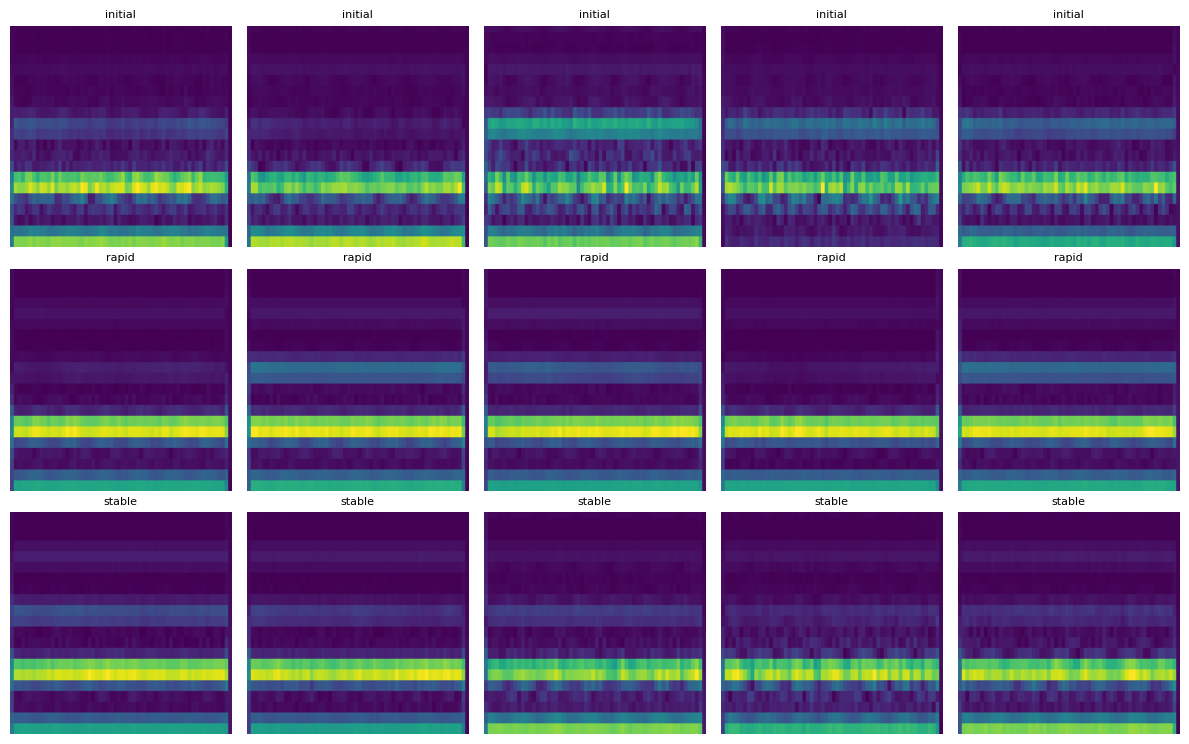

In [10]:

fig, axes = plt.subplots(len(class_names), 5, figsize=(12, len(class_names)*2.5))

for idx, cls in enumerate(class_names):
    cls_path = os.path.join(data_path, cls)
    all_files = os.listdir(cls_path)
    random_files = random.sample(all_files, min(5, len(all_files)))
    
    for j, filename in enumerate(random_files):
        img_path = os.path.join(cls_path, filename)
        img = Image.open(img_path)
        
        axes[idx, j].imshow(img)
        axes[idx, j].set_title(f"{cls}", fontsize=8)
        axes[idx, j].axis('off')

plt.tight_layout()
plt.show()

# TEST NEW

In [5]:
# Experiment configuration
EXPERIMENT_NAME = "test"
DATA_PATH = "../data/processed/dataset_Fz_stft_2000"
N_SAMPLES = 2000
BATCH_SIZE = 64
EPOCHS = 10
LEARNING_RATE = 0.001


transform = models.get_vit_transforms()
model = models.create_vit_model(num_classes=3, device=device,  freeze_backbone=False, unfreeze_patch_embed=False)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_fn = nn.CrossEntropyLoss()

In [ ]:

# from torchinfo import summary
# summary(
#     model=model,
#     input_size=(BATCH_SIZE, 3, 224, 224),
#     col_names=["input_size", "output_size", "num_params", "trainable"],
#     col_width=20,
#     row_settings=["var_names"]
# )

In [6]:
results = experiments.run_experiment(
    data_path=DATA_PATH,
    model=model,
    optimizer=optimizer,
    loss_fn=loss_fn,
    transform=transform,
    device=device,
    n_samples=N_SAMPLES,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS
)


initial: 2000 train, 500 test
rapid: 2000 train, 500 test
stable: 2000 train, 500 test
Classes: ['initial', 'rapid', 'stable']


 10%|█         | 1/10 [02:12<19:52, 132.53s/it]

Epoch: 1 | train_loss: 0.9482 | train_acc: 0.5485 | test_loss: 0.6302 | test_acc: 0.6947


 20%|██        | 2/10 [03:51<15:03, 113.00s/it]

Epoch: 2 | train_loss: 0.5711 | train_acc: 0.7366 | test_loss: 0.5336 | test_acc: 0.7400


 30%|███       | 3/10 [05:29<12:20, 105.81s/it]

Epoch: 3 | train_loss: 0.4793 | train_acc: 0.7780 | test_loss: 0.6586 | test_acc: 0.6948


 40%|████      | 4/10 [06:55<09:49, 98.26s/it] 

Epoch: 4 | train_loss: 0.4589 | train_acc: 0.7913 | test_loss: 0.4633 | test_acc: 0.7809


 50%|█████     | 5/10 [09:07<09:11, 110.29s/it]

Epoch: 5 | train_loss: 0.4437 | train_acc: 0.7999 | test_loss: 0.4518 | test_acc: 0.7844


 60%|██████    | 6/10 [13:34<10:54, 163.61s/it]

Epoch: 6 | train_loss: 0.4553 | train_acc: 0.7959 | test_loss: 0.4636 | test_acc: 0.7734


 70%|███████   | 7/10 [15:00<06:55, 138.37s/it]

Epoch: 7 | train_loss: 0.4456 | train_acc: 0.8018 | test_loss: 0.4633 | test_acc: 0.7867


 80%|████████  | 8/10 [16:25<04:02, 121.14s/it]

Epoch: 8 | train_loss: 0.4557 | train_acc: 0.7996 | test_loss: 0.4870 | test_acc: 0.7825


 90%|█████████ | 9/10 [17:49<01:49, 109.67s/it]

Epoch: 9 | train_loss: 0.4389 | train_acc: 0.8006 | test_loss: 0.4604 | test_acc: 0.7780


100%|██████████| 10/10 [19:16<00:00, 115.62s/it]

Epoch: 10 | train_loss: 0.4102 | train_acc: 0.8157 | test_loss: 0.4826 | test_acc: 0.7693

Training time: 1156.21 seconds (19.27 minutes)


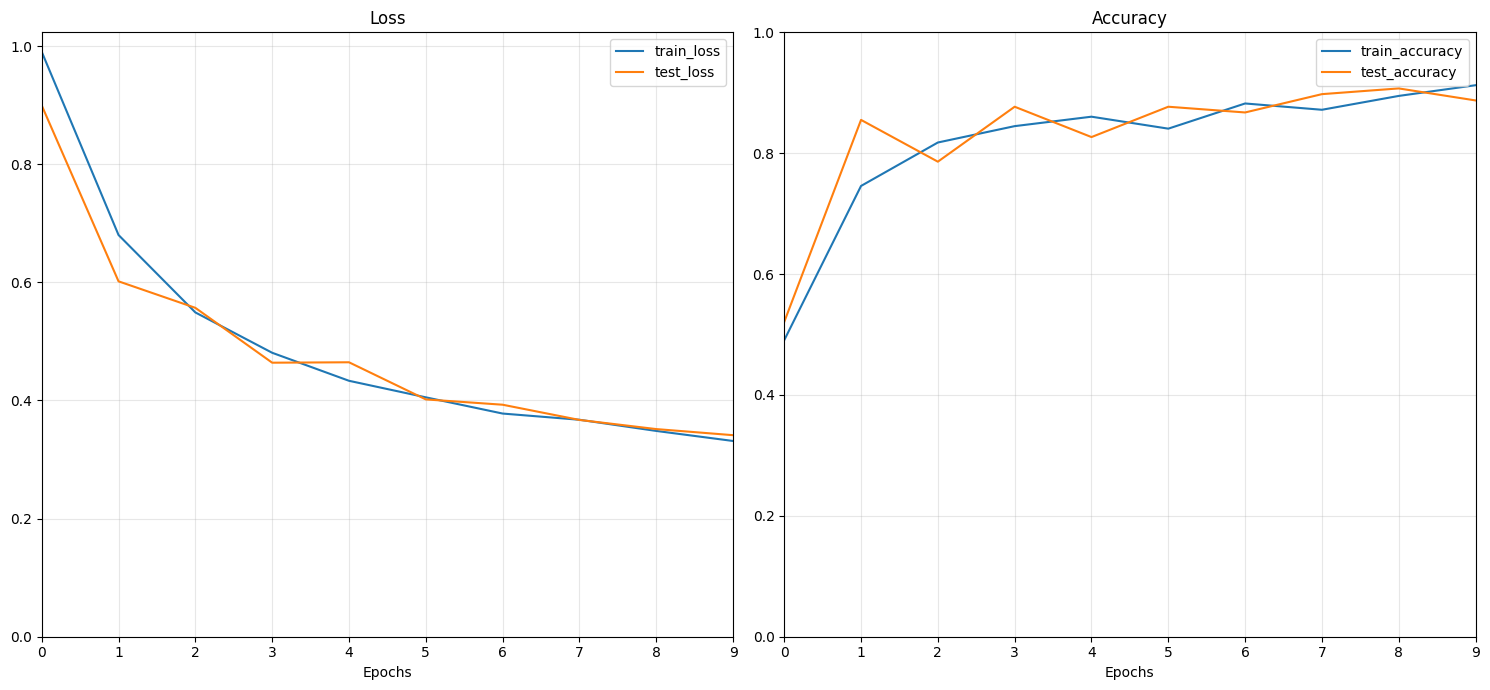

In [4]:
utils.plot_loss_curves(results)

In [6]:
save_path = f"../experiments/results/{EXPERIMENT_NAME}/model.pth"
utils.save_model(model, save_path)

Model saved to ../experiments/results/test_vit/model.pth


In [3]:
# Experiment configuration
EXPERIMENT_NAME = "test"
DATA_PATH = "../data/processed/dataset_Fz_stft_2000"
N_SAMPLES = 100
BATCH_SIZE = 32
EPOCHS = 5
LEARNING_RATE = 0.001


transform = models.get_vit_transforms()
model = models.create_vit_model(num_classes=3, device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_fn = nn.CrossEntropyLoss()

In [4]:
# Just add run_name!
results = experiments.run_experiment_mlflow(
    data_path="../data/processed/dataset_Fz_stft_2000",
    model=model,
    optimizer=optimizer,
    loss_fn=loss_fn,
    transform=transform,
    device=device,
    n_samples=100,
    epochs=EPOCHS,
    run_name="Tensortest_3"   # ← Add this!
)

initial: 100 train, 25 test
rapid: 100 train, 25 test
stable: 100 train, 25 test
Classes: ['initial', 'rapid', 'stable']


 20%|██        | 1/5 [00:06<00:25,  6.37s/it]

Epoch: 1 | train_loss: 0.6607 | train_acc: 0.7802 | test_loss: 0.6719 | test_acc: 0.6932


 40%|████      | 2/5 [00:10<00:14,  4.78s/it]

Epoch: 2 | train_loss: 0.5086 | train_acc: 0.8719 | test_loss: 0.6757 | test_acc: 0.6534


 60%|██████    | 3/5 [00:13<00:08,  4.31s/it]

Epoch: 3 | train_loss: 0.4532 | train_acc: 0.8635 | test_loss: 0.5650 | test_acc: 0.7547


 80%|████████  | 4/5 [00:17<00:04,  4.12s/it]

Epoch: 4 | train_loss: 0.4106 | train_acc: 0.8677 | test_loss: 0.5988 | test_acc: 0.7055


100%|██████████| 5/5 [00:21<00:00,  4.28s/it]

Epoch: 5 | train_loss: 0.3691 | train_acc: 0.8979 | test_loss: 0.5556 | test_acc: 0.7765

Training time: 21.41 seconds (0.36 minutes)


In [3]:
# Setup
transform = models.get_vit_transforms()
model = models.create_vit_model(num_classes=3, device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

# Config
config = {
    "experiment_name": "test",
    "data_path": "../data/processed/dataset_Fz_stft_2000",
    "n_samples": 100,
    "batch_size": 32,
    "epochs": 5,
    "split": 0.8
}

# Run
results = experiments.run_experiment_2(
    config=config,
    model=model,
    optimizer=optimizer,
    loss_fn=loss_fn,
    transform=transform,
    device=device,
    save_results=True,
    save_model=False
)

initial: 100 train, 25 test
rapid: 100 train, 25 test
stable: 100 train, 25 test
Classes: ['initial', 'rapid', 'stable']


 20%|██        | 1/5 [00:06<00:25,  6.48s/it]

Epoch: 1 | train_loss: 0.9785 | train_acc: 0.5104 | test_loss: 0.8305 | test_acc: 0.7008


 40%|████      | 2/5 [00:10<00:14,  4.91s/it]

Epoch: 2 | train_loss: 0.6704 | train_acc: 0.7792 | test_loss: 0.7254 | test_acc: 0.6534


 60%|██████    | 3/5 [00:14<00:08,  4.42s/it]

Epoch: 3 | train_loss: 0.5452 | train_acc: 0.8042 | test_loss: 0.6224 | test_acc: 0.7140


 80%|████████  | 4/5 [00:17<00:04,  4.17s/it]

Epoch: 4 | train_loss: 0.4608 | train_acc: 0.8823 | test_loss: 0.6413 | test_acc: 0.6638


100%|██████████| 5/5 [00:21<00:00,  4.34s/it]

Epoch: 5 | train_loss: 0.4174 | train_acc: 0.8698 | test_loss: 0.5709 | test_acc: 0.7765

Training time: 21.72 seconds (0.36 minutes)
Saved config and results to ../experiments/results/test



Training on: dataset_Fz_stft_2000

initial: 2000 train, 500 test
rapid: 2000 train, 500 test
stable: 2000 train, 500 test
Classes: ['initial', 'rapid', 'stable']


  5%|▌         | 1/20 [01:56<36:59, 116.79s/it]

Epoch: 1 | train_loss: 0.4686 | train_acc: 0.8405 | test_loss: 0.3617 | test_acc: 0.8503


 10%|█         | 2/20 [03:05<26:34, 88.57s/it] 

Epoch: 2 | train_loss: 0.2901 | train_acc: 0.8976 | test_loss: 0.2946 | test_acc: 0.8876


 15%|█▌        | 3/20 [04:15<22:38, 79.89s/it]

Epoch: 3 | train_loss: 0.2554 | train_acc: 0.9066 | test_loss: 0.2709 | test_acc: 0.8906


 20%|██        | 4/20 [05:24<20:12, 75.79s/it]

Epoch: 4 | train_loss: 0.2368 | train_acc: 0.9114 | test_loss: 0.2633 | test_acc: 0.8919


 25%|██▌       | 5/20 [06:33<18:21, 73.46s/it]

Epoch: 5 | train_loss: 0.2255 | train_acc: 0.9207 | test_loss: 0.2518 | test_acc: 0.9025


 30%|███       | 6/20 [07:43<16:50, 72.15s/it]

Epoch: 6 | train_loss: 0.2158 | train_acc: 0.9192 | test_loss: 0.2503 | test_acc: 0.8987


 35%|███▌      | 7/20 [08:53<15:27, 71.34s/it]

Epoch: 7 | train_loss: 0.2142 | train_acc: 0.9188 | test_loss: 0.2448 | test_acc: 0.9006


 40%|████      | 8/20 [10:02<14:07, 70.63s/it]

Epoch: 8 | train_loss: 0.2080 | train_acc: 0.9223 | test_loss: 0.2385 | test_acc: 0.8999


 45%|████▌     | 9/20 [11:11<12:52, 70.20s/it]

Epoch: 9 | train_loss: 0.2007 | train_acc: 0.9249 | test_loss: 0.2560 | test_acc: 0.9023


 50%|█████     | 10/20 [12:20<11:38, 69.88s/it]

Epoch: 10 | train_loss: 0.2014 | train_acc: 0.9235 | test_loss: 0.2231 | test_acc: 0.9142


 55%|█████▌    | 11/20 [13:29<10:26, 69.61s/it]

Epoch: 11 | train_loss: 0.1964 | train_acc: 0.9273 | test_loss: 0.2247 | test_acc: 0.9145


 60%|██████    | 12/20 [14:38<09:15, 69.45s/it]

Epoch: 12 | train_loss: 0.1964 | train_acc: 0.9231 | test_loss: 0.2247 | test_acc: 0.9051


 65%|██████▌   | 13/20 [15:48<08:06, 69.43s/it]

Epoch: 13 | train_loss: 0.1939 | train_acc: 0.9238 | test_loss: 0.2318 | test_acc: 0.9064


 70%|███████   | 14/20 [16:57<06:55, 69.28s/it]

Epoch: 14 | train_loss: 0.1893 | train_acc: 0.9264 | test_loss: 0.2290 | test_acc: 0.9079


 75%|███████▌  | 15/20 [18:06<05:46, 69.38s/it]

Epoch: 15 | train_loss: 0.1859 | train_acc: 0.9280 | test_loss: 0.2032 | test_acc: 0.9229


 80%|████████  | 16/20 [19:16<04:37, 69.40s/it]

Epoch: 16 | train_loss: 0.1843 | train_acc: 0.9300 | test_loss: 0.2418 | test_acc: 0.9061


 85%|████████▌ | 17/20 [20:25<03:28, 69.47s/it]

Epoch: 17 | train_loss: 0.1806 | train_acc: 0.9307 | test_loss: 0.2016 | test_acc: 0.9281


 90%|█████████ | 18/20 [21:35<02:19, 69.56s/it]

Epoch: 18 | train_loss: 0.1798 | train_acc: 0.9306 | test_loss: 0.2052 | test_acc: 0.9159


 95%|█████████▌| 19/20 [22:45<01:09, 69.54s/it]

Epoch: 19 | train_loss: 0.1806 | train_acc: 0.9281 | test_loss: 0.2042 | test_acc: 0.9193


100%|██████████| 20/20 [23:54<00:00, 71.72s/it]

Epoch: 20 | train_loss: 0.1761 | train_acc: 0.9317 | test_loss: 0.2002 | test_acc: 0.9194

Training time: 1434.32 seconds (23.91 minutes)
Saved config and results to ../experiments/results/vit_dataset_Fz_stft_2000

Training on: dataset_Fz_stft_log_10000



initial: 2000 train, 500 test
rapid: 2000 train, 500 test
stable: 2000 train, 500 test
Classes: ['initial', 'rapid', 'stable']


  5%|▌         | 1/20 [02:03<39:02, 123.29s/it]

Epoch: 1 | train_loss: 0.5966 | train_acc: 0.7606 | test_loss: 0.4411 | test_acc: 0.8290


 10%|█         | 2/20 [03:18<28:27, 94.88s/it] 

Epoch: 2 | train_loss: 0.3971 | train_acc: 0.8507 | test_loss: 0.3609 | test_acc: 0.8678


 15%|█▌        | 3/20 [04:33<24:18, 85.78s/it]

Epoch: 3 | train_loss: 0.3425 | train_acc: 0.8721 | test_loss: 0.3235 | test_acc: 0.8877


 20%|██        | 4/20 [05:48<21:44, 81.54s/it]

Epoch: 4 | train_loss: 0.3119 | train_acc: 0.8851 | test_loss: 0.2946 | test_acc: 0.8882


 25%|██▌       | 5/20 [07:02<19:45, 79.05s/it]

Epoch: 5 | train_loss: 0.2874 | train_acc: 0.8929 | test_loss: 0.2777 | test_acc: 0.8958


 30%|███       | 6/20 [08:17<18:06, 77.58s/it]

Epoch: 6 | train_loss: 0.2708 | train_acc: 0.8966 | test_loss: 0.2615 | test_acc: 0.9063


 35%|███▌      | 7/20 [09:32<16:37, 76.71s/it]

Epoch: 7 | train_loss: 0.2602 | train_acc: 0.8988 | test_loss: 0.2528 | test_acc: 0.9104


 40%|████      | 8/20 [10:47<15:13, 76.10s/it]

Epoch: 8 | train_loss: 0.2479 | train_acc: 0.9050 | test_loss: 0.2422 | test_acc: 0.9086


 45%|████▌     | 9/20 [12:01<13:51, 75.62s/it]

Epoch: 9 | train_loss: 0.2413 | train_acc: 0.9053 | test_loss: 0.2386 | test_acc: 0.9095


 50%|█████     | 10/20 [13:16<12:33, 75.35s/it]

Epoch: 10 | train_loss: 0.2327 | train_acc: 0.9108 | test_loss: 0.2345 | test_acc: 0.9147


 55%|█████▌    | 11/20 [14:31<11:16, 75.15s/it]

Epoch: 11 | train_loss: 0.2240 | train_acc: 0.9125 | test_loss: 0.2266 | test_acc: 0.9146


 60%|██████    | 12/20 [15:46<10:00, 75.02s/it]

Epoch: 12 | train_loss: 0.2181 | train_acc: 0.9137 | test_loss: 0.2258 | test_acc: 0.9115


 65%|██████▌   | 13/20 [17:00<08:44, 74.86s/it]

Epoch: 13 | train_loss: 0.2117 | train_acc: 0.9179 | test_loss: 0.2174 | test_acc: 0.9171


 70%|███████   | 14/20 [18:15<07:29, 74.87s/it]

Epoch: 14 | train_loss: 0.2076 | train_acc: 0.9204 | test_loss: 0.2103 | test_acc: 0.9290


 75%|███████▌  | 15/20 [19:30<06:13, 74.78s/it]

Epoch: 15 | train_loss: 0.2052 | train_acc: 0.9210 | test_loss: 0.2176 | test_acc: 0.9122


 80%|████████  | 16/20 [20:44<04:59, 74.76s/it]

Epoch: 16 | train_loss: 0.1999 | train_acc: 0.9200 | test_loss: 0.2062 | test_acc: 0.9229


 85%|████████▌ | 17/20 [21:59<03:44, 74.79s/it]

Epoch: 17 | train_loss: 0.1945 | train_acc: 0.9227 | test_loss: 0.2088 | test_acc: 0.9173


 90%|█████████ | 18/20 [23:14<02:29, 74.78s/it]

Epoch: 18 | train_loss: 0.1934 | train_acc: 0.9219 | test_loss: 0.2039 | test_acc: 0.9214


 95%|█████████▌| 19/20 [24:29<01:14, 74.77s/it]

Epoch: 19 | train_loss: 0.1932 | train_acc: 0.9210 | test_loss: 0.1957 | test_acc: 0.9300


100%|██████████| 20/20 [25:43<00:00, 77.18s/it]

Epoch: 20 | train_loss: 0.1876 | train_acc: 0.9229 | test_loss: 0.2256 | test_acc: 0.9040

Training time: 1543.67 seconds (25.73 minutes)
Saved config and results to ../experiments/results/vit_dataset_Fz_stft_log_10000

Training on: dataset_Fz_stft_log_25000



initial: 2000 train, 500 test
rapid: 2000 train, 500 test
stable: 2000 train, 500 test
Classes: ['initial', 'rapid', 'stable']


  5%|▌         | 1/20 [03:49<1:12:46, 229.80s/it]

Epoch: 1 | train_loss: 0.7114 | train_acc: 0.7416 | test_loss: 0.5300 | test_acc: 0.8204


 10%|█         | 2/20 [06:36<57:49, 192.76s/it]  

Epoch: 2 | train_loss: 0.4580 | train_acc: 0.8483 | test_loss: 0.4356 | test_acc: 0.8312


 15%|█▌        | 3/20 [09:23<51:12, 180.73s/it]

Epoch: 3 | train_loss: 0.3853 | train_acc: 0.8656 | test_loss: 0.3722 | test_acc: 0.8628


 20%|██        | 4/20 [12:09<46:41, 175.09s/it]

Epoch: 4 | train_loss: 0.3447 | train_acc: 0.8803 | test_loss: 0.3356 | test_acc: 0.8704


 25%|██▌       | 5/20 [14:56<43:02, 172.19s/it]

Epoch: 5 | train_loss: 0.3200 | train_acc: 0.8837 | test_loss: 0.3171 | test_acc: 0.8820


 30%|███       | 6/20 [17:42<39:40, 170.02s/it]

Epoch: 6 | train_loss: 0.2983 | train_acc: 0.8940 | test_loss: 0.2989 | test_acc: 0.8854


 35%|███▌      | 7/20 [21:24<40:30, 186.96s/it]

Epoch: 7 | train_loss: 0.2888 | train_acc: 0.8932 | test_loss: 0.2842 | test_acc: 0.8915


 40%|████      | 8/20 [24:23<36:56, 184.67s/it]

Epoch: 8 | train_loss: 0.2774 | train_acc: 0.9000 | test_loss: 0.2813 | test_acc: 0.8889


 45%|████▌     | 9/20 [27:09<32:46, 178.75s/it]

Epoch: 9 | train_loss: 0.2667 | train_acc: 0.8989 | test_loss: 0.2729 | test_acc: 0.8921


 50%|█████     | 10/20 [29:56<29:09, 174.96s/it]

Epoch: 10 | train_loss: 0.2565 | train_acc: 0.9055 | test_loss: 0.2616 | test_acc: 0.8994


 55%|█████▌    | 11/20 [32:42<25:51, 172.41s/it]

Epoch: 11 | train_loss: 0.2499 | train_acc: 0.9075 | test_loss: 0.2571 | test_acc: 0.8993


 60%|██████    | 12/20 [35:29<22:44, 170.62s/it]

Epoch: 12 | train_loss: 0.2478 | train_acc: 0.9071 | test_loss: 0.2528 | test_acc: 0.9016


 65%|██████▌   | 13/20 [38:15<19:45, 169.39s/it]

Epoch: 13 | train_loss: 0.2367 | train_acc: 0.9148 | test_loss: 0.2427 | test_acc: 0.9023


 70%|███████   | 14/20 [41:02<16:50, 168.42s/it]

Epoch: 14 | train_loss: 0.2333 | train_acc: 0.9142 | test_loss: 0.2417 | test_acc: 0.9034


 75%|███████▌  | 15/20 [43:48<13:58, 167.77s/it]

Epoch: 15 | train_loss: 0.2274 | train_acc: 0.9184 | test_loss: 0.2355 | test_acc: 0.9078


 80%|████████  | 16/20 [46:35<11:10, 167.52s/it]

Epoch: 16 | train_loss: 0.2222 | train_acc: 0.9177 | test_loss: 0.2466 | test_acc: 0.8981


 85%|████████▌ | 17/20 [49:21<08:21, 167.22s/it]

Epoch: 17 | train_loss: 0.2226 | train_acc: 0.9166 | test_loss: 0.2298 | test_acc: 0.9033


 90%|█████████ | 18/20 [52:09<05:34, 167.22s/it]

Epoch: 18 | train_loss: 0.2169 | train_acc: 0.9200 | test_loss: 0.2276 | test_acc: 0.9065


 95%|█████████▌| 19/20 [54:55<02:47, 167.13s/it]

Epoch: 19 | train_loss: 0.2108 | train_acc: 0.9227 | test_loss: 0.2246 | test_acc: 0.9091


100%|██████████| 20/20 [57:42<00:00, 173.15s/it]

Epoch: 20 | train_loss: 0.2108 | train_acc: 0.9233 | test_loss: 0.2218 | test_acc: 0.9104

Training time: 3462.93 seconds (57.72 minutes)
Saved config and results to ../experiments/results/vit_dataset_Fz_stft_log_25000

Training on: dataset_Vz_stft_2000



initial: 2000 train, 500 test
rapid: 2000 train, 500 test
stable: 2000 train, 500 test
Classes: ['initial', 'rapid', 'stable']


  5%|▌         | 1/20 [01:56<36:54, 116.55s/it]

Epoch: 1 | train_loss: 0.6580 | train_acc: 0.7210 | test_loss: 0.5440 | test_acc: 0.7661


 10%|█         | 2/20 [03:05<26:38, 88.78s/it] 

Epoch: 2 | train_loss: 0.4992 | train_acc: 0.7960 | test_loss: 0.4826 | test_acc: 0.7902


 15%|█▌        | 3/20 [04:15<22:37, 79.86s/it]

Epoch: 3 | train_loss: 0.4562 | train_acc: 0.8090 | test_loss: 0.4635 | test_acc: 0.8043


 20%|██        | 4/20 [05:24<20:10, 75.68s/it]

Epoch: 4 | train_loss: 0.4255 | train_acc: 0.8237 | test_loss: 0.4247 | test_acc: 0.8249


 25%|██▌       | 5/20 [06:32<18:15, 73.02s/it]

Epoch: 5 | train_loss: 0.4042 | train_acc: 0.8353 | test_loss: 0.4116 | test_acc: 0.8318


 30%|███       | 6/20 [07:41<16:42, 71.62s/it]

Epoch: 6 | train_loss: 0.3875 | train_acc: 0.8536 | test_loss: 0.4002 | test_acc: 0.8413


 35%|███▌      | 7/20 [08:49<15:16, 70.53s/it]

Epoch: 7 | train_loss: 0.3694 | train_acc: 0.8568 | test_loss: 0.3988 | test_acc: 0.8328


 40%|████      | 8/20 [09:58<13:57, 69.78s/it]

Epoch: 8 | train_loss: 0.3579 | train_acc: 0.8625 | test_loss: 0.3836 | test_acc: 0.8482


 45%|████▌     | 9/20 [11:06<12:42, 69.35s/it]

Epoch: 9 | train_loss: 0.3520 | train_acc: 0.8681 | test_loss: 0.3673 | test_acc: 0.8544


 50%|█████     | 10/20 [12:14<11:30, 69.02s/it]

Epoch: 10 | train_loss: 0.3382 | train_acc: 0.8735 | test_loss: 0.3571 | test_acc: 0.8592


 55%|█████▌    | 11/20 [13:23<10:21, 69.01s/it]

Epoch: 11 | train_loss: 0.3264 | train_acc: 0.8792 | test_loss: 0.3547 | test_acc: 0.8673


 60%|██████    | 12/20 [14:32<09:11, 68.90s/it]

Epoch: 12 | train_loss: 0.3238 | train_acc: 0.8760 | test_loss: 0.3386 | test_acc: 0.8770


 65%|██████▌   | 13/20 [15:40<08:00, 68.71s/it]

Epoch: 13 | train_loss: 0.3118 | train_acc: 0.8887 | test_loss: 0.3333 | test_acc: 0.8725


 70%|███████   | 14/20 [16:49<06:52, 68.70s/it]

Epoch: 14 | train_loss: 0.3046 | train_acc: 0.8876 | test_loss: 0.3273 | test_acc: 0.8770


 75%|███████▌  | 15/20 [17:57<05:43, 68.68s/it]

Epoch: 15 | train_loss: 0.3002 | train_acc: 0.8906 | test_loss: 0.3207 | test_acc: 0.8807


 80%|████████  | 16/20 [19:05<04:33, 68.43s/it]

Epoch: 16 | train_loss: 0.2920 | train_acc: 0.8972 | test_loss: 0.3292 | test_acc: 0.8762


 85%|████████▌ | 17/20 [20:14<03:25, 68.49s/it]

Epoch: 17 | train_loss: 0.2881 | train_acc: 0.8964 | test_loss: 0.3168 | test_acc: 0.8798


 90%|█████████ | 18/20 [21:22<02:16, 68.33s/it]

Epoch: 18 | train_loss: 0.2866 | train_acc: 0.8969 | test_loss: 0.3227 | test_acc: 0.8741


 95%|█████████▌| 19/20 [22:31<01:08, 68.40s/it]

Epoch: 19 | train_loss: 0.2792 | train_acc: 0.9016 | test_loss: 0.3256 | test_acc: 0.8721


100%|██████████| 20/20 [23:39<00:00, 70.97s/it]

Epoch: 20 | train_loss: 0.2727 | train_acc: 0.9030 | test_loss: 0.2976 | test_acc: 0.8885

Training time: 1419.43 seconds (23.66 minutes)
Saved config and results to ../experiments/results/vit_dataset_Vz_stft_2000

Training on: dataset_Vz_stft_log_10000



initial: 2000 train, 500 test
rapid: 2000 train, 500 test
stable: 2000 train, 500 test
Classes: ['initial', 'rapid', 'stable']


  5%|▌         | 1/20 [02:01<38:24, 121.28s/it]

Epoch: 1 | train_loss: 0.7863 | train_acc: 0.6500 | test_loss: 0.5983 | test_acc: 0.7652


 10%|█         | 2/20 [03:15<28:06, 93.71s/it] 

Epoch: 2 | train_loss: 0.5501 | train_acc: 0.7884 | test_loss: 0.4993 | test_acc: 0.8096


 15%|█▌        | 3/20 [04:30<24:04, 84.95s/it]

Epoch: 3 | train_loss: 0.4731 | train_acc: 0.8199 | test_loss: 0.4474 | test_acc: 0.8251


 20%|██        | 4/20 [05:44<21:31, 80.70s/it]

Epoch: 4 | train_loss: 0.4254 | train_acc: 0.8375 | test_loss: 0.4130 | test_acc: 0.8392


 25%|██▌       | 5/20 [06:58<19:36, 78.43s/it]

Epoch: 5 | train_loss: 0.3975 | train_acc: 0.8504 | test_loss: 0.3866 | test_acc: 0.8544


 30%|███       | 6/20 [08:12<17:56, 76.91s/it]

Epoch: 6 | train_loss: 0.3721 | train_acc: 0.8625 | test_loss: 0.3752 | test_acc: 0.8535


 35%|███▌      | 7/20 [09:26<16:27, 75.94s/it]

Epoch: 7 | train_loss: 0.3503 | train_acc: 0.8702 | test_loss: 0.3614 | test_acc: 0.8557


 40%|████      | 8/20 [10:40<15:04, 75.41s/it]

Epoch: 8 | train_loss: 0.3365 | train_acc: 0.8772 | test_loss: 0.3458 | test_acc: 0.8648


 45%|████▌     | 9/20 [11:55<13:45, 75.04s/it]

Epoch: 9 | train_loss: 0.3237 | train_acc: 0.8835 | test_loss: 0.3297 | test_acc: 0.8711


 50%|█████     | 10/20 [13:09<12:27, 74.71s/it]

Epoch: 10 | train_loss: 0.3167 | train_acc: 0.8816 | test_loss: 0.3232 | test_acc: 0.8724


 55%|█████▌    | 11/20 [14:23<11:11, 74.61s/it]

Epoch: 11 | train_loss: 0.3029 | train_acc: 0.8912 | test_loss: 0.3189 | test_acc: 0.8747


 60%|██████    | 12/20 [15:37<09:55, 74.49s/it]

Epoch: 12 | train_loss: 0.2910 | train_acc: 0.8967 | test_loss: 0.3051 | test_acc: 0.8781


 65%|██████▌   | 13/20 [16:51<08:39, 74.28s/it]

Epoch: 13 | train_loss: 0.2836 | train_acc: 0.8998 | test_loss: 0.3122 | test_acc: 0.8795


 70%|███████   | 14/20 [18:05<07:24, 74.16s/it]

Epoch: 14 | train_loss: 0.2786 | train_acc: 0.8999 | test_loss: 0.2930 | test_acc: 0.8857


 75%|███████▌  | 15/20 [19:19<06:10, 74.15s/it]

Epoch: 15 | train_loss: 0.2695 | train_acc: 0.9054 | test_loss: 0.3026 | test_acc: 0.8828


 80%|████████  | 16/20 [20:33<04:56, 74.13s/it]

Epoch: 16 | train_loss: 0.2711 | train_acc: 0.9035 | test_loss: 0.2905 | test_acc: 0.8839


 85%|████████▌ | 17/20 [21:47<03:42, 74.19s/it]

Epoch: 17 | train_loss: 0.2582 | train_acc: 0.9091 | test_loss: 0.2777 | test_acc: 0.8929


 90%|█████████ | 18/20 [23:02<02:28, 74.17s/it]

Epoch: 18 | train_loss: 0.2570 | train_acc: 0.9089 | test_loss: 0.2766 | test_acc: 0.8927


 95%|█████████▌| 19/20 [24:16<01:14, 74.09s/it]

Epoch: 19 | train_loss: 0.2475 | train_acc: 0.9131 | test_loss: 0.2743 | test_acc: 0.8903


100%|██████████| 20/20 [25:30<00:00, 76.50s/it]

Epoch: 20 | train_loss: 0.2458 | train_acc: 0.9120 | test_loss: 0.2702 | test_acc: 0.8969

Training time: 1530.01 seconds (25.50 minutes)
Saved config and results to ../experiments/results/vit_dataset_Vz_stft_log_10000

Training on: dataset_Vz_stft_log_25000



initial: 2000 train, 500 test
rapid: 2000 train, 500 test
stable: 2000 train, 500 test
Classes: ['initial', 'rapid', 'stable']


  5%|▌         | 1/20 [04:01<1:16:20, 241.07s/it]

Epoch: 1 | train_loss: 0.7269 | train_acc: 0.6999 | test_loss: 0.6004 | test_acc: 0.7563


 10%|█         | 2/20 [06:56<1:00:49, 202.72s/it]

Epoch: 2 | train_loss: 0.4973 | train_acc: 0.8135 | test_loss: 0.4948 | test_acc: 0.8084


 15%|█▌        | 3/20 [09:51<53:49, 190.00s/it]  

Epoch: 3 | train_loss: 0.4177 | train_acc: 0.8527 | test_loss: 0.4353 | test_acc: 0.8327


 20%|██        | 4/20 [12:46<49:05, 184.11s/it]

Epoch: 4 | train_loss: 0.3697 | train_acc: 0.8702 | test_loss: 0.3963 | test_acc: 0.8546


 25%|██▌       | 5/20 [15:42<45:13, 180.87s/it]

Epoch: 5 | train_loss: 0.3407 | train_acc: 0.8786 | test_loss: 0.3654 | test_acc: 0.8755


 30%|███       | 6/20 [18:37<41:48, 179.15s/it]

Epoch: 6 | train_loss: 0.3144 | train_acc: 0.8872 | test_loss: 0.3449 | test_acc: 0.8676


 35%|███▌      | 7/20 [21:33<38:32, 177.92s/it]

Epoch: 7 | train_loss: 0.2960 | train_acc: 0.8939 | test_loss: 0.3434 | test_acc: 0.8727


 40%|████      | 8/20 [24:32<35:41, 178.46s/it]

Epoch: 8 | train_loss: 0.2864 | train_acc: 0.8933 | test_loss: 0.3133 | test_acc: 0.8882


 45%|████▌     | 9/20 [28:31<36:09, 197.23s/it]

Epoch: 9 | train_loss: 0.2657 | train_acc: 0.9057 | test_loss: 0.3061 | test_acc: 0.8917


 50%|█████     | 10/20 [31:26<31:44, 190.49s/it]

Epoch: 10 | train_loss: 0.2560 | train_acc: 0.9100 | test_loss: 0.2962 | test_acc: 0.8939


 55%|█████▌    | 11/20 [34:22<27:53, 185.91s/it]

Epoch: 11 | train_loss: 0.2503 | train_acc: 0.9105 | test_loss: 0.2834 | test_acc: 0.8967


 60%|██████    | 12/20 [37:17<24:21, 182.63s/it]

Epoch: 12 | train_loss: 0.2386 | train_acc: 0.9193 | test_loss: 0.2872 | test_acc: 0.8927


 65%|██████▌   | 13/20 [40:12<21:03, 180.45s/it]

Epoch: 13 | train_loss: 0.2357 | train_acc: 0.9146 | test_loss: 0.2682 | test_acc: 0.8980


 70%|███████   | 14/20 [43:07<17:52, 178.77s/it]

Epoch: 14 | train_loss: 0.2265 | train_acc: 0.9189 | test_loss: 0.2619 | test_acc: 0.9040


 75%|███████▌  | 15/20 [46:03<14:49, 177.83s/it]

Epoch: 15 | train_loss: 0.2184 | train_acc: 0.9270 | test_loss: 0.2568 | test_acc: 0.9071


 80%|████████  | 16/20 [48:58<11:48, 177.02s/it]

Epoch: 16 | train_loss: 0.2128 | train_acc: 0.9269 | test_loss: 0.2583 | test_acc: 0.9020


 85%|████████▌ | 17/20 [51:53<08:49, 176.55s/it]

Epoch: 17 | train_loss: 0.2109 | train_acc: 0.9280 | test_loss: 0.2532 | test_acc: 0.9084


 90%|█████████ | 18/20 [54:49<05:52, 176.11s/it]

Epoch: 18 | train_loss: 0.2031 | train_acc: 0.9312 | test_loss: 0.2416 | test_acc: 0.9051


 95%|█████████▌| 19/20 [57:43<02:55, 175.65s/it]

Epoch: 19 | train_loss: 0.1991 | train_acc: 0.9315 | test_loss: 0.2357 | test_acc: 0.9123


100%|██████████| 20/20 [1:00:39<00:00, 181.96s/it]

Epoch: 20 | train_loss: 0.1950 | train_acc: 0.9322 | test_loss: 0.2386 | test_acc: 0.9175

Training time: 3639.12 seconds (60.65 minutes)
Saved config and results to ../experiments/results/vit_dataset_Vz_stft_log_25000


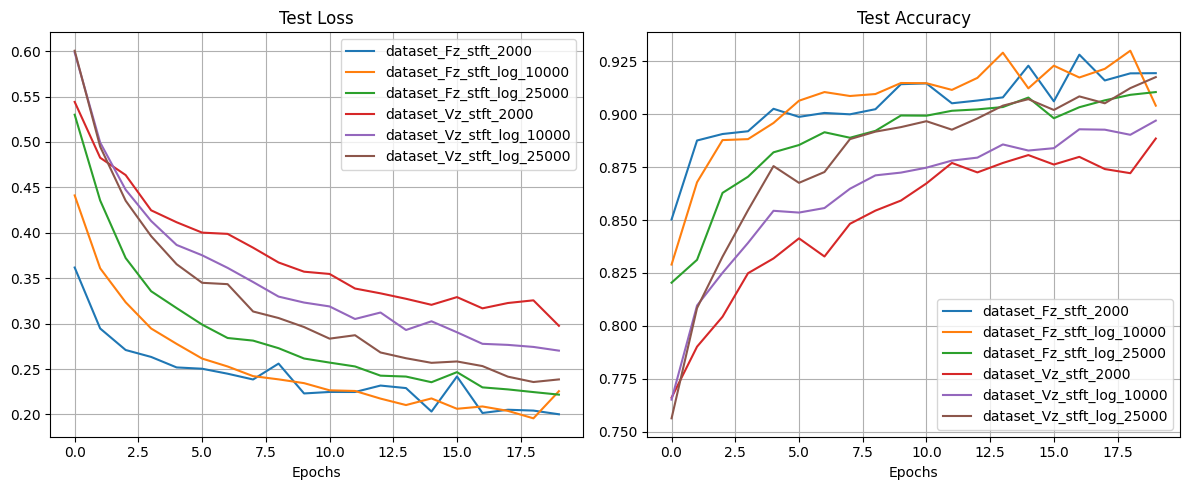

In [6]:
loss_fn = nn.CrossEntropyLoss()

datasets_to_test = [
    {"name": "dataset_Fz_stft_2000", "num_classes": 3},
    {"name": "dataset_Fz_stft_log_10000", "num_classes": 3},
    {"name": "dataset_Fz_stft_log_25000", "num_classes": 3},
    {"name": "dataset_Vz_stft_2000", "num_classes": 3},
    {"name": "dataset_Vz_stft_log_10000", "num_classes": 3},
    {"name": "dataset_Vz_stft_log_25000", "num_classes": 3}
]

all_results = {}

for dataset in datasets_to_test:
    dataset_name = dataset['name']
    print(f"\n{'='*60}")
    print(f"Training on: {dataset_name}")
    print(f"{'='*60}\n")
    
    transform = models.get_vit_transforms()
    model = models.create_vit_model(num_classes=dataset['num_classes'], device=device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    config = {
        "experiment_name": f"vit_{dataset_name}",
        "data_path": f"../data/processed/{dataset_name}",
        "n_samples": 2000,
        "batch_size": 64,
        "epochs": 20,
    }
    
    results = experiments.run_experiment_2(
        config=config,
        model=model,
        optimizer=optimizer,
        loss_fn=loss_fn,
        transform=transform,
        device=device,
        save_results=True
    )
    
    all_results[dataset_name] = results

# Compare
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for dataset_name, results in all_results.items():
    epochs = range(len(results['test_loss']))
    axes[0].plot(epochs, results['test_loss'], label=dataset_name)
    axes[1].plot(epochs, results['test_acc'], label=dataset_name)

axes[0].set_title('Test Loss')
axes[0].set_xlabel('Epochs')
axes[0].legend()
axes[0].grid(True)

axes[1].set_title('Test Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
loss_fn = nn.CrossEntropyLoss()

datasets_to_test = [
    {"name": "dataset_Fz_stft_2000", "num_classes": 3},
    {"name": "dataset_Fz_stft_log_10000", "num_classes": 3},
    {"name": "dataset_Fz_stft_log_25000", "num_classes": 3},
    {"name": "dataset_Vz_stft_2000", "num_classes": 3},
    {"name": "dataset_Vz_stft_log_10000", "num_classes": 3},
    {"name": "dataset_Vz_stft_log_25000", "num_classes": 3}
]

all_results_2 = {}

for dataset in datasets_to_test:
    dataset_name = dataset['name']
    print(f"\n{'='*60}")
    print(f"Training on: {dataset_name}")
    print(f"{'='*60}\n")
    
    transform = models.get_resnet_transforms()
    model = models.create_resnet_model(num_classes=dataset['num_classes'], device=device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    config = {
        "experiment_name": f"resnet50_{dataset_name}",
        "data_path": f"../data/processed/{dataset_name}",
        "n_samples": 2000,
        "batch_size": 64,
        "epochs": 20,
    }
    
    results = experiments.run_experiment_2(
        config=config,
        model=model,
        optimizer=optimizer,
        loss_fn=loss_fn,
        transform=transform,
        device=device,
        save_results=True
    )
    
    all_results_2[dataset_name] = results

# Compare
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for dataset_name, results in all_results_2.items():
    epochs = range(len(results['test_loss']))
    axes[0].plot(epochs, results['test_loss'], label=dataset_name)
    axes[1].plot(epochs, results['test_acc'], label=dataset_name)

axes[0].set_title('Test Loss')
axes[0].set_xlabel('Epochs')
axes[0].legend()
axes[0].grid(True)

axes[1].set_title('Test Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


Training on: dataset_Fz_stft_2000



Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\DV Group/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 115MB/s] 


initial: 2000 train, 500 test
rapid: 2000 train, 500 test
stable: 2000 train, 500 test
Classes: ['initial', 'rapid', 'stable']


  5%|▌         | 1/20 [02:07<40:27, 127.75s/it]

Epoch: 1 | train_loss: 0.5551 | train_acc: 0.8184 | test_loss: 0.3750 | test_acc: 0.8755


 10%|█         | 2/20 [03:19<28:31, 95.08s/it] 

Epoch: 2 | train_loss: 0.3490 | train_acc: 0.8645 | test_loss: 0.3069 | test_acc: 0.8956
